# The Deep Learning Book (Simplified)
## Part II - Modern Practical Deep Networks
*This is a series of blog posts on the [Deep Learning book](http://deeplearningbook.org)
where we are attempting to provide a summary of each chapter highlighting the concepts 
that we found to be most important so that other people can use it as a starting point
for reading the chapters, while adding further explanations on few areas that we found difficult to grasp. Please refer [this](http://www.deeplearningbook.org/contents/notation.html) for more clarity on 
notation.*


## Chapter 8: Optimization for Training Deep Models

There are many types of optimization problems involved in deep learning, with the toughest one being that of training a neural network. The main theme of the chapter is to focus on one type of optimization - finding the parameters $\theta$ that reduce a cost function $J(\theta)$. <br>

The chapter is organized as follows:

**1. How Learning Differs from Pure Optimization** <br>
**2. Challenges in Neural Network Optimization** <br>
**3. Basic Algorithms** <br>
**4. Parameter Initialization Strategies** <br>
**5. Algorithms with Adaptive Learning Rates** <br>
**6. Approximate Second-Order Methods** <br>
**7. Optimization Strategies and Meta-Algorithms** 

### 1. How Learning differs from Pure Optimization

- In Machine Learning (ML), we care about a certain performance measure *P* (for e.g. accuracy) defined w.r.t the test set and optimize *$J(\theta)$* (for e.g. cross-entropy loss) with the hope that it improves *P* as well. In pure optimization, optimizing *$J(\theta)$* is the final goal.

- The expected generalization error (**risk**) is taken over the true data-generating distribution $p_{data}$. If we do have that, it becomes an optimization problem. When we don't have $p_{data}$ but a finite training set, we have a ML problem. The latter can be converted back to an optimization problem by replace $p_{data}$ with the empirical distribution, $\tilde{p}_{data}$ obtained from the training set, thereby reducing the empirical risk. This is called empirical risk minimization (ERM) and although it might look relatively similar to optimizationthere are two main problems:
    - ERM is prone to overfitting with the possibility of the dataset being learned by high capacity models.
    - ERM might not be feasible. Most optimization algorithms now are based on Gradient Descent (GD) which may not work with various loss functions like 0-1 loss (as it is not differentiable)


In [22]:
from sklearn.metrics import log_loss, zero_one_loss
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
y_true = np.ones(201, dtype='float')
y_pred = np.linspace(start=0, stop=1.0, num=201) # only the last prediction is correct

In [24]:
# storing the losses for each example
zero_one_losses = []
cross_entropy_losses = []

for i in range(len(y_true)):
    zero_one_loss_value = zero_one_loss([y_true[i]], [y_pred[i] >= 0.5])
    cross_entropy_loss_value = log_loss([y_true[i]], [y_pred[i]], labels=[0, 1])
    zero_one_losses.append(zero_one_loss_value)
    cross_entropy_losses.append(cross_entropy_loss_value)

In [25]:
# neat visualization hack
y_max_allowed = 5
for i, loss in enumerate(cross_entropy_losses):
    if loss <= 5:
        index_to_start = i
        break

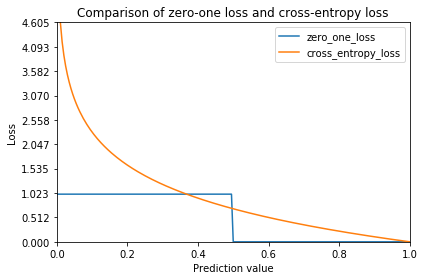

In [26]:
plt.plot(y_pred, zero_one_losses, label='zero_one_loss')
plt.plot(y_pred[index_to_start:], cross_entropy_losses[index_to_start:], label='cross_entropy_loss')
plt.legend(loc='best')
plt.xlabel('Prediction value')
plt.ylabel('Loss')
plt.title('Comparison of zero-one loss and cross-entropy loss')
plt.xticks(np.linspace(0, 1.4, 8))
plt.yticks(np.linspace(0, np.max(cross_entropy_losses[index_to_start:]), 10))
plt.tight_layout()
plt.margins(0)
plt.savefig('images/loss_comparison.png')
plt.show()

    
- It is for the reasons mentioned above that a **surrogate loss function** (SLF) is used instead that acts as a proxy. E.g. the negative log-likelihood of the true class is used as a surrogate for 0-1 loss. Using a SLF might even turn out to be beneficial as you can keep continuing to obtain a better test error by pushing the classes even further apart to get a more reliable classifier.

- Another common difference is that training might be halted following some convergence criterion based on Early Stopping to prevent overfitting, when the derivative of the surrogate loss function might still be large. This is different from pure optimization which is halted only when the derivative becomes very small. If you're not familiar with Early Stopping, I'd recommend you to look at our [previous post](https://medium.com/inveterate-learner/deep-learning-book-chapter-7-regularization-for-deep-learning-937ff261875c) where we talk about Early Stopping and other regularization techniques.

- In ML optimization algorithms that objective function decomposes as a sum over the examples and we can perform updates by randomly sampling a batch of examples and taking the average over those examples. The Standard Error of the mean estimated from *n* examples is given by $\frac {\sigma} {\sqrt{n}}$ indicating that as we include more examples for making an update, the returns of additonal examples in improving the error is less than linear. Thus, if we use 100 and 10000 example s to make an update, the latter takes 100 times more compute, but reducing the error only by a factor of 10. Thus, it's better to compute rapid approximate updates rather than a slow exact update.

- There are 3 types of sampling based algorithms - **batch gradient descent (BGD)** where the entire training set is used to make a single update, **stochastic gradient descent (SGD)** where a single example is used to make an update and **mini-batch gradient descent (MBGD)** where a batch (not to be confused with BGD) of examples is randomly sampled from the entire training set and is used to make an update. *MBGD is nowadays commonly refered to as SGD*. It is a common practise to use batch sizes as powers of 2 to offer better runtime with certain hardware. Small batches tend to have a regularizing effect because of the noise they inject as each update is made by seeing only a very small portion of the entire training set, a.k.a., a batch of samples.

- The minibatches should be selected randomly. It is sufficient to shuffle the dataset once and iterate over it multiple times. In the first epoch, the network sees each example for the first time and hence, the estimate of gradient is an *unbiased* estimate of the gradient of the true generalization error. However, from the second epoch onwards, the estimate becomes biased as it is resampling from data that it has already seen.


### 2. Challenges in Neural Network Optimization

The optimization problem for training neural networks is generally nonconvex. Some of the challenges faced are mentioned below:

- **Ill-conditioning of the Hessian Matrix**: Can cause the SGD to get stuck in a sense that even very small steps increase the cost function. Moving by a factor of $-\epsilon \mathbf{g}$  would add the term given below to the cost function. Ill-conditioning is to happen when the first term exceeds the second term. In many cases, $\mathbf{g}^TH\mathbf{g}$ does increase significantly leading to slower learning due to reduced learning rate. Thus, while the gradient norm might be increasing, it can still lead to successful training.

$$ \frac{1}{2}\epsilon^2\mathbf{g}^TH\mathbf{g} - \epsilon\mathbf{g}^T\mathbf{g} $$

- **Local minima**: Nearly any DL model is guaranteed to have an extremely large number of local minima (LM) arising due to the model identifiability problem.

![minima](images/local_minima.gif)

A model is said to be identifiable if a sufficiently large training set can rule out all but one setting of the model parameters. In case of neural networks, we can obtain equivalent models by swapping the position of the neurons. Thus, they are not identifiable.

![model_identifiability](images/model_identifiability.png)

Swapping the two hidden nodes leads to equivalent models. Thus, even after having a sufficiently large training set, there is not a unique setting of parameters. This is the model identifiability problem that neural networks suffer from.

However, all the local minima caused due to this have the same value, thus not being a problem. However, if local minima with high cost are common, it becomes a serious problem. Many points other than local minima can lead to low gradients. Nowadays, it's common to aim for a low but not minimal cost value.


- **Plateaus, Saddle Points and Other Flat Regions**: Saddle point (SP) is another type of point with zero gradient where some points around it have higher value and the others have lower. Intuitively, this means that a saddle point acts as both a local minima for some neighbors and a local maxima for the others. Thus, Hessian at SP has both +ve and -ve eigenvalues. 

![saddle](images/saddle_point.png)

For many classes of random functions, saddle points become more common at high dimensions  with the ratio of number of SPs to LMs growing exponentially with *n* for an n-dimensional space. Many random functions have an amazing property that near points with lost cost, the Hessian tends to take up mostly positive eigenvalues. SGD empirically tends to rapidly avoid encountering a high-cost saddle point. There also might be wide, flat regions of constant value, thereby having a zero gradient. These can be problematic if the cost is high in these regions.

![plateau](images/plateau.png)

- **Cliffs and Exploding Gradients**: NNs might sometimes have extremely steep regions resembling cliffs due to the repeated multiplication of weights. At the edge of such a cliff, an update step might throw the parameters extremely far. It can be taken care of by using **gradient clipping (GC)**. The gradient indicates only the direction in which to make the update. If the GD update proposes making a very large step, GC intervenes to reduce the step size.
![gradient clipping](images/gradient_clipping.png)

- **Long-Term Dependencies**: This problem is encountered when the NN becomes sufficiently deep. For example, if the same weight matrix $\mathbf{W}$ is used in each layer, after *t* steps, we'd get $\mathbf{W}^t$. Using the eigendecomposition of $\mathbf{W}$:

$$ \mathbf{W} = \mathbf{V} diag(\lambda) \mathbf{V}^T $$
$$ \mathbf{W}^t = \mathbf{V} diag(\lambda)^t \mathbf{V}^T $$

Thus, any eigenvalues not near an absolute value of 1 would either explode or vanish leading to the [**vanishing and exploding gradient problem**](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/). The use of the same weight matrix is especially the case in RNNs where this is a serious problem.

![vanish explode gradient](images/exploding_vanishing_gradient.jpg)

- **Inexact Gradients**: Most optimization algorithms use a noisy/biased estimate of the gradient in cases where the estimate is based on sampling, while in cases where the true gradient is intractable for e.g. in the case of training a [Restricted Boltzmann Machine (RBM)](https://deeplearning4j.org/restrictedboltzmannmachine), an approximation of the gradient is used. For RBM, the [contrastive divergence algorithm](https://deeplearning4j.org/glossary.html#contrastivedivergence) gives a technique for approximating the gradient of its intractable log-likelihood


- Neural Networks might not end up at any critical point at all and such critical points might not even necessarily exist. A lot of the problems might be avoided if there exists a space connected to reasonably directly to the solution by a path that local descent can follow and if we are able to initialize learning within that well-behaved space. Thus, choosing good initial points should be studied.

### 3. Basic Algorithms

- **Stochastic Gradient Descent**: This has already been described before but there are certain things that should be kept in mind regarding SGD. The learning rate $\epsilon$ is a very important parameter for SGD. $\epsilon$ should be reduced after each epoch in general. This is due to the fact that the random sampling of batches acts as a source of noise which might make SGD keep oscillating around the minima without actually reaching it (the image [Source: https://goo.gl/tq6Xof] below shows this). The true gradient of the total cost function (involving the entire dataset) actually becomes 0 when we reach the minimum. Hence, BGD can use a fixed learning rate. <br>
![decrease lr](images/decrease_lr.png)
The following conditions guarantee convergence in case of SGD: 
![convergence of sgd](images/sgd_convergence.png) 
Practically, epsilon is decreased linearly until iteration $\tau$: 
![lr update](images/lr_update.png)

The main question is how to choose $\epsilon_0$. Setting it too low makes the training proceed slowly which might lead to the algorithm being stuck at a high cost value. Setting it too high would lead to large oscillations which might even push the learning outside the optimal region. The best way is to monitor the first several iterations and set the learning rate to be higher than the best performing one, but not too high to cause instability. <br> <br>

![lr_high_low](images/lr_high_low.png)

A big advantage of SGD is that the time taken to compute a weight update doesn't grow with the number of training examples as each update is computed after observing a batch of samples which is independent of the total number of training examples. Theoretically, BGD makes the error rate $O(\frac{1}{k})$ after *k* iterations whereas SGD makes it $O(\frac{1}{\sqrt{k}})$. However, SGD compensates for this with its advantages after a few iterations along with the ability to make rapid updates in the case of a large training set.

- **Momentum**: The momentum algorithm accumulates the exponentially decaying moving average of past gradients (called as velocity) and uses it as the direction in which to take the next step. Momentum is given by mass times velocity, which is equal to velocity if we're using unit mass. The momentum update is given by:

![momentum](images/momentum_update.png)

The step size (earlier equal to learning rate * gradient) now depends on how large and aligned the sequence of gradients are. If the gradients at each iteration point in the same direction (say g), it will lead to a higher value of the step size as they just keep accumulating. Once it reaches a constant (terminal) velocity, the step size becomes ϵ || g|| / (1 - α). Thus, using α as 0.9 makes the speed 10 times. Common values of α are 0.5, 0.9 and 0.99.

![momentum_visual](images/momentum.png)

Viewing it as the Newtonian dynamics of a particle sliding down a hill, the momentum algorithm consists of solving a set of differential equations via numerical simulation. There are two kinds of forces involved as shown below:

![momentum_newton](images/momentum_ball_roll.png)
Momentum can be seen as two forces operating together. 1) Proportional to the negative of the gradient such that whenever it descends a steep part of the surface, it gathers speed and continues sliding in that direction until it goes uphill again. 2) A viscous drag force (friction) proportional to -v(t) without the presence of which the particle would keep oscillating back and forth as the negative of the gradient would keep forcing it to move downhill . Viscous force is suitable as it is weak enough to allow the gradient to cause motion and strong enough to resist any motion if the gradient doesn't justify moving.

Read more about momentum in this excellent blog post by [distill.ai](http://www.distill.ai/): [Why Momentum Really Works](https://distill.pub/2017/momentum/).


- **Nesterov Momentum**: This is a slight modification of the usual momentum equation. Here, the gradient is calculated after applying the current velocity to the parameters, which can be viewed as adding a correction factor.

![nesterov](images/nesterov.png)

The intuition behind Nesterov momentum is that upon being at a point θ in the parameter space, the momentum update is going to shift the point by $\alpha$v. So, we are soon going to end up in the vicinity of ($\theta$ + $\alpha$v). Thus, it might be better to compute the gradient from that point onward. The figure below describes this visually:

![nesterov_intuition](images/nesterov.jpeg)

### 4. Parameter Initialization Strategies

Training algorithms for deep learning models are iterative in nature and require the specification of an initial point, which is extremely crucial as it decides whether the algorithm would converge or not and if it does, then is it as a point with a high cost or low cost. We have limited understanding of neural network optimization but the one property that we know with complete certainty is that the initialization should break symmetry. This means that if two hidden units are connected to the same input units, then these should have different initialization or else the gradient would update both the units in the same way and we don't learn anything new by using an additional unit. The idea of having each unit learn something different motivates random initialization of weights which is also computationally cheaper. 

Biases are often chosen heuristically (zero mostly) and only the weights are randomly initialized, almost always from a Gaussian or uniform distribution. The scale of the distribution is of utmost concern. Large weights might have better symmetry-breaking effect but might lead to chaos (extreme sensitivity to small perturbations in the input) and exploding values during forward & back propagation. As an example of how large weights might lead to chaos, consider that there's a slight noise adding $\epsilon$ to the input. Now, we if did just a simple linear transformation like `W * x`, the $\epsilon$ noise would add a factor of W * $\epsilon$ to the output. In case the weights are high, this ends up making a significant contribution to the output. SGD and its variants tend to halt in areas near the initial values, thereby expressing a prior that the path to the final parameters from the initial values is discoverable by steepest descent algorithms. A more mathematical explanation for the symmetry breaking can be found in the [Appendix](https://github.com/dalmia/Deep-Learning-Book-Chapter-Summaries/blob/master/Appendix.ipynb).

Various suggestions have been made for appropriate initialization of the parameters. The most commonly used ones include sampling the weights of each fully-connected layer having `m` inputs and `n` outputs uniformly from the following distributions:
- $U(-\frac{1}{\sqrt{m}}, \frac{1}{\sqrt{m}})$
- $U(-\sqrt{\frac{6}{n+m}}, \sqrt{\frac{6}{m+n}})$

U(a, b) represents the uniform distribution where the probability of each value between a and b, a and b inclusive, is 1/(b-a). The probability of every other value is 0. 

![uniform dist](images/uniform_distribution.png)

These have already been incorporated into most commonly used Deep Learning frameworks so that you can just specify which initializer to use and the framework takes care of sampling appropriately. For e.g. [Keras](https://keras.io/), which is a very famous deep learning framework, has a module called [initializers](https://keras.io/initializers/), where the second type of distribution is implemented as glorot_uniform .

These initializations have already been incorporated into the most commonly used Deep Learning frameworks nowadays so that you can just specify which initializer to use and the framework takes care of sampling appropriately. For e.g. Keras, which is a very famous deep learning framework, has a module called initializers, where the second distribution (among the 2 mentioned above) is implemented as glorot_uniform .

One drawback of using 1 / √m as the standard deviation is that the weights end up being small when a layer has too many input/output units. Motivated by the idea to have the total amount of input to each unit independent of the number of input units m, Sparse initialization sets each unit to have exactly k non-zero weights. However, it takes a long time for GD to correct incorrect *large values* and hence, this initialization might cause problems.

If the weights are too small, the range of activations across the mini-batch will shrink as the activations propagate forward through the network.By repeatedly identifying the ﬁrst layer with unacceptably small activations and increasing its weights, it is possible to eventually obtain a network with reasonable initial activations throughout.

The biases are relatively easier to choose. Setting the biases to zero is compatible with most weight initialization schemes except for a few cases for e.g. when used for an output unit, to prevent saturation at initialization or when using unit as a gate for making a decision. Refer to the [chapter](https://www.deeplearningbook.org/contents/optimization.html#pf1f) for details.

### 5. Algorithms with Adaptive Learning Rates

- **AdaGrad**: As mentioned in above, it is important to incrementally decrease the learning rate for faster convergence. Instead of manually reducing the learning rate after each (or several) epochs, a better approach is to adapt the learning rate as the training progresses. This can be done by scaling the learning rates of *each model parameter* individually inversely proportional to the square root of the sum of historical squared values of the gradient. In the parameter update equation below, r is initialized with 0 and the multiplication in the update step happens element-wise as mentioned. Since the gradient value would be different for each parameter, the learning rate is scaled differently for each parameter too. Thus, those parameters having a large gradient have a large decrease in the learning rate as the learning rate might be too high leading to oscillations or it might be approaching the minima but having large learning rate might cause it to jump over the minima as explained in the figure below, because of which the learning rate should be decreased for better convergence, while those with small gradients have a small decrease in the learning rate as they might have already approached their respective minima and should not be pushed away from that. Even if they have not, reducing the learning rate too much would reduce the gradient even further leading to slower learning.

![adagrad update](images/adagrad.png)

![adagrad requirement](images/convex.png)

This figure illustrates the need to reduce the learning rate if gradient is large in case of a single parameter. 1) One step of gradient descent representing a large gradient value. 2) Result of reducing the learning rate - moves towards the minima 3) Scenario if the learning rate was not reduced - it would have jumped over the minima.

However, accumulation of squared gradients from the very beginning can lead to excessive and premature decrease in the learning rate. Consider that we had a model with only 2 parameters (for simplicity) and both the initial gradients are 1000. After some iterations, the gradient of one of the parameters has reduced to 100 but that of the other parameter is still around 800. However, because of the accumulation at each update, the accumulated gradient would still have almost the same value. For e.g. let the accumulated gradients at each step for the Parameter 1 be `1000 + 900 + 700 + 400 + 100 = 3100, 1/3100=0.0003` and that for Parameter 2 be: `1000 + 900 + 850 + 800 + 750 = 4300, 1/4300 = 0.0002`. This would lead to a similar decrease in the learning rates for both the parameters, even though the parameter having the lower gradient might have its learning rate reduced too much leading to slower learning.


![adagrad problem](images/adagrad_problem.png)

The figure above explains the problem with AdaGrad. Accumulated gradients can cause the learning rate to be reduced far too much in the later stages leading to slower learning


- **RMSProp**: RMSProp addresses the problem caused by accumulated gradients in AdaGrad. It modifies the gradient accumulation step to an exponentially weighted moving average in order to discard history from the extreme past. The RMSProp update is given by:

![rmsprop](images/rmsprop.png)

In the figure, **ρ** is the weighing used for exponential averaging. As more updates are made, the contribution of past gradient values are reduced since **ρ** < 1 
and **ρ** > **ρ**² > **ρ**³ …

This allows the algorithm to converge rapidly after finding a convex bowl, as if it were an instance of AdaGrad initialized within that bowl. Let me explain why this is so. Consider the figure below. The region represented by 1 indicates usual RMSProp parameter updates as given by the update equation, which is nothing but exponentially averaged AdaGrad updates. Once the optimization process lands on A, it essentially lands at the top of a convex bowl. At this point, intuitively, all the updates before A can be seen to be forgotten due to the exponential averaging and it can be seen as if (exponentially averaged) AdaGrad updates start from point A onwards.

![rmsprop convergence](images/nonconvex.png)
 
The figure above explains the intuition behind RMSProp. 1) Usual parameter updates 2) Once it reaches the convex bowl, exponentially weighted averaging would cause the effect of earlier gradients to reduce and to simplify, we can assume their contribution to be zero. This can be seen as if AdaGrad had been used with the training initiated inside the convex bowl


- **Adam**: Adapted from "adaptive moments", it focuses on combining RMSProp and Momentum. Firstly, it views Momentum as an estimate of the first-order moment and RMSProp as that of the second moment. The weight  update for Adam is given by:

![adam_update](images/adam_update.png)

Secondly, since s and r are initialized as zeros, the authors observed a bias during the initial steps of training thereby adding a correction term for both the moments to account for their initialization near the origin. As an example of what is the effect of this bias correction, we'll look at the values of **s** and **r** for a single parameter (in which case everything is now represented as a scalar). Let's first understand what would happen if there was no bias correction. Since *s* (notice that this is not in bold as we are looking at the value for a single parameter and the *s* here is a scalar) is initialized as zero, after the first iteration, the value of *s* would be (1 - $\rho_1$) X g and that of *r* would be (1 - $\rho_2$) X g². The [preferred values](https://arxiv.org/pdf/1412.6980.pdf) for  $\rho_1$ and  $\rho_2$ are 0.9 and 0.99 respectively. Thus, the initial values of s and r are pretty small and this gets compounded as the training progress. However, if we now use bias correction, after the first iteration, the value of s is just g and that of r is just g². This gets rid of the bias that occurs in the initial phase of training. A major advantage of Adam is that it's [fairly robust](https://stats.stackexchange.com/questions/232719/what-is-the-reason-that-the-adam-optimizer-is-considered-robust-to-the-value-of) to the choice of these hyperparameters, i.e.  $\rho_1$ and  $\rho_2$.

The figure below shows the comparison between the various optimization methods discussed above. It can be clearly seen that algorithms with adaptive learning rates provide faster convergence:

![optimizers_comparison](images/optimizers_comparison.gif)


### 6.  Approximate Second-Order Methods

The optimization algorithms that we've looked at till now involved computing only the first  derivative. But there are many methods which involve higher order derivatives as well. The main problem with these algorithms are that they are not practically feasible in their vanilla form and so, certain methods are used to approximate the values of the derivatives. We explain three such methods, all of which use empirical risk as the objective function:

- **Newton's Method**: This is the most common higher-order derivative method used. It makes use of the curvature of the loss function via its second-order derivative to arrive at the optimal point. Using the second-order Taylor Series expansion to approximate the $\mathbf{\it{J}(\theta)}$ around a point $\mathbf{\theta_o}$ and ignoring derivatives of higher order, we get:

![newton](images/newton.png)

We know that we get a critical point for any function f(x) by solving for f'(x) = 0. We get the following critical point of the above equation (refer to the [Appendix](https://github.com/dalmia/Deep-Learning-Book-Chapter-Summaries/blob/master/Appendix.ipynb) for proof):

![newton point](images/newton_point.png)

For quadratic surfaces (i.e. where cost function is quadratic), this directly gives the optimal result in one step whereas gradient descent would still need to iterate. However, for surfaces that are not quadratic, as long as the [Hessian remains positive definite](https://math.stackexchange.com/questions/1985889/why-how-does-the-determinant-of-the-hessian-matrix-combined-with-the-2nd-deriva), we can obtain the optimal point through a 2-step iterative process - 1) Get the inverse of the Hessian and 2) update the parameters.


[Saddle points](https://medium.com/inveterate-learner/deep-learning-book-chapter-8-optimization-for-training-deep-models-part-i-20ae75984cb2#c3a9) are problematic for Newton's method. If all the eigenvalues are not positive, Newton's method might cause the updates to move in the wrong direction. A way to avoid this is to add regularization:

![regularization](images/regularization.png)

However, if there is a strong negative curvature, $\alpha$ needs to be sufficiently large to offset the negative eigenvalues in which case the Hessian becomes dominated by the diagonal matrix thereby leading to an update which becomes the standard gradient divided by $\alpha$. 

![hessian_as_gd](images/hessian_as_gd.png)

Another problem restricting the use of Newton's method is the computational cost. It takes $O(k^3)$ time to calculate the inverse of the Hessian where $k$ is the number of parameters. It's not uncommon for Deep Neural Networks to have about a million parameters and since the parameters are updated every iteration, this inverse needs to be calculated at every iteration, which is not computationally feasible.


- **Conjugate Gradients**: One weakness of the method of steepest descent (i.e. GD) is that [line searches](http://www.deeplearningbook.org/contents/numerical.html#pf7) happen along the direction of the gradient. Suppose the previous search direction is $d_{t-1}$. Once the search terminates (which it does when the gradient along the current gradient direction vanishes) at the minimum, the next search direction, $d_{t}$ is given by the gradient at that point, which is orthogonal to $d_{t-1}$ (because if it's not orthogonal, it'll have some component along $d_{t-1}$ which cannot be true as at the minimum, the gradient along $d_{t-1}$ has vanished). 
Upon getting the minimum along the current search direction, the minimum along the previous search direction is not preserved, undoing, in a sense, the progress made in previous search direction.

![conjugate gradient](images/conjugate_gradient.png)

In the method of conjugate gradients, we seek a search direction that is conjugate to the previous line search direction:

![conjugate_gd](images/conjugate_gd.png)

with $d_t$ and $d_{t-1}$ being called as **conjugate** if $d^T_tHd_{t-1} = 0$.
where $\beta_t$ decides how much of $d_{t-1}$ is added back to the current search direction. There are two popular choices for $\beta_t$ - Fletcher-Reeves and Polak-Ribière. These discussions assumed the cost function to be quadratic. To extend the concept to work for training neural networks, there is one additional change. Since it's no longer quadratic, there's no guarantee anymore than the conjugate direction would preserve the minimum in the previous search directions. Thus, the algorithm includes occasional resets where the method of conjugate gradients is restarted with line search along the unaltered gradient.

- **BFGS**: This algorithm tries to bring the advantages of Newton's method without the additonal computational burden by approximating $H^{-1}$ by $M_t$, which is iteratively refined using low-rank updates. Finally, line search is conducted along the direction  $M_tg_t$. BFGS requires storing the matrix $M_t$ which takes $O(n^2)$ memory making it infeasible. An approach called Limited Memory BFGS (L-BFGS) has been proposed to tackle this infeasibility by computing the matrix $M_t$ using the same method as BFGS but assuming that $M_{t-1}$ is the identity matrix.

### 7. Optimization Strategies and Meta-Learning Algorithms

- **Batch Normalization**: Batch normalization (BN) is one of the most exciting innovations in Deep learning that has significantly stabilized the learning process and allowed faster convergence rates. The intuition behind batch normalization is as follows: Most of the Deep Learning networks are compositions of many layers (or functions) and the gradient with respect to one layer is taken considering the other layers to be constant. However, in practise all the layers are updated simultaneously and this can lead to unexpected results. For example, let $\tilde{y}$ = x $W_1$ $W_2$ … $W_n$. Here, $\tilde{y}$ is a linear function of x but not a linear function of the weights. Suppose the gradient is given by g and we now intend to reduce $\tilde{y}$ by 0.1. Using first-order Taylor Series approximation, taking a step of ϵg would reduce $\tilde{y}$ by $\epsilon g^T g$ . Thus, $\epsilon$ should be $\frac{0.1}{g^T g}$ just using the first-order information. However, higher order effects also creep in as the updated $\tilde{y}$ is given by:

![update](images/batch_norm.png)

An example of a second-order term would be $\epsilon^2$ $g^1$ $g^2$ $\prod w_i$. $\prod w_i$ can be negligibly small or exponentially high depending on whether the individual weights are less than or greater than 1. Since the updates to one layer is so strongly dependent on the other layers, choosing an appropriate learning rate is tough. Batch normalization takes care of this problem by using an efficient reparameterization of almost any deep network. Given a matrix of activations, H, the normalization is given by: $ H' = \frac{H-\mu}{\sigma}$, where the subtraction and division is [broadcasted](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html).

![update](images/batch-normalization.png)

Going back to the earlier example of $\tilde{y}$, let the activations of layer l be given by $h_{l-1}$. Then $h_{l-1}$ = x $W_1$ $W_2$ … $W_{l-1}$. Now, if x is drawn from a unit Gaussian, then $h_{l-1}$ also comes from a Gaussian, however, not of zero mean and unit variance, as it is a linear transformation of x. BN makes it zero mean and unit variance. Therefore, $\tilde{y}$ = $W_l$ $h_{l-1}$ and thus, the learning now becomes much simpler as the parameters at the lower layers mostly do not have any effect. This simplicity was definitely achieved by rendering the lower layers useless. However, in a realistic deep network with non-linearities, the lower layers remain useful. Finally, the complete reparameterization of BN is given by replacing H with $\gamma$H' + $\beta$. This is done to retain its expressive power and the fact that the mean is solely determined by $\beta$. Also, among the choice of normalizating X or XW + B, the authors recommend the latter, specifically XW, since B becomes redundant because of $\beta$. Practically, this means that when we are using the Batch Normalization layer, the biases should be turned off. In a deep learning framework like [Keras](http://keras.io), this can be done by setting the parameter *use_bias=False* in the Convolutional layer.

- **Coordinate Descent**: Generally, a single weight update is made by taking the gradient with respect to every parameter. However, in cases where some of the parameters might be independent (discussed below) of the remaining, it might be more efficient to take the gradient with respect to those independent sets of parameters separately for making updates. Let me clarify that with an example. Suppose we have the following cost function:

![coordinate descent](images/coordinate_descent.png)

This cost function describes the learning problem called sparse coding. Here, **H** refers to the sparse representation of **X** and **W** is the set of weights used to linearly decode **H** to retrieve **X**. An explanation of why this cost function enforces the learning of a sparse representation of X follows. The first term of the cost function penalizes values far from 0 (positive or negative because of the modulus, |H|, operator. This enforces most of the values to be 0, thereby sparse. The second term is pretty self-explanatory in that it compensates the difference between **X** and **H** being linearly transformed by **W**, thereby enforcing them to take the same value. In this way, **H** is now learned as a sparse "representation" of **X**. The cost function generally consists of additionally a [regularization](https://medium.com/inveterate-learner/deep-learning-book-chapter-7-regularization-for-deep-learning-937ff261875c) term like [weight decay](https://medium.com/inveterate-learner/deep-learning-book-chapter-7-regularization-for-deep-learning-937ff261875c#e021), which has been avoided for simplicity. Here, we can divide the entire list of parameters into two sets, **W** and **H**. Minimizing the cost function with respect to any of these sets of parameters is a convex problem. Coordinate Descent (CD) refers to minimizing the cost function with respect to only 1 parameter at a time. It has been shown that repeatedly cycling through all the parameters, we are guaranteed to arrive at a local minima. If instead of 1 parameter, we take a set of parameters as we did before with **W** and **H**, it is called block coordinate descent (the interested reader should explore [Alternating Minimization](http://www.mit.edu/~rakhlin/6.883/lectures/lecture07.pdf)). CD makes sense if either the parameters are clearly separable into independent groups or if optimizing with respect to certain set of parameters is more efficient than with respect to others.

A visual explanation for coordinate descent:

![coord desc 2](images/coordinate_descent2.png)

The points A, B, C and D indicates the locations in the parameter space where coordinate descent landed after each gradient step. ([Source](https://www.researchgate.net/figure/Coordinate-Descent-CD-CD-algorithm-searches-along-one-coordinate-direction-in-each_fig2_262805949))


Coordinate descent may [fail terribly](https://www.deeplearningbook.org/contents/optimization.html#pf30) when one variable influences the optimal value of another variable.

- **Polyak Averaging**: Polyak averaging consists of averaging several points in the parameter space that the optimization algorithm traverses through. So, if the algorithm encounters the points θ(1), θ(2), … during optimization, the output of Polyak averaging is:

![polyak](images/polyak.png)

The figure below explains the intuition behind Polyak averaging:

![polyak](images/polyak_intuition.png)

Most optimization problems in deep learning are non-convex where the path taken by the optimization algorithm is quite complicated and it might happen that a point visited in the distant past might be quite far from the current point in the parameter space. Thus, including such a point in the distant past might not be useful, which is why an exponentially decaying running average is taken. This scheme where the recent iterates are weighted more than the past ones is called **Polyak-Ruppert Averaging**:

![polyak](images/polyak_exp.png)

- **Supervised Pre-training**: Sometimes it's hard to directly train to solve for a specific task. Instead it might be better to train for solving a simpler task and use that as an initialization point for training to solve the more challenging task. As an intuition for why this seems logical, consider that you didn't have any background in integration and were asked to learn how to compute the following integral:

![dvance integral](images/advance_int.jpg)

If you're anyone close to a normal person, your first reaction would be:

![meme](images/math_meme.jpg)

However, wouldn't it be better if you were asked to understand the more basic integrations first:

![easy int](images/easy_int.gif)

I hope you understand what I meant with this example - learning a simpler task would put you in a better position to understand the more complex task. This particular strategy of training to solve a simpler task before facing the herculean one is called pretraining. A particular type of pretraining, called **greedy supervised pretraining**, firstly breaks a given supervised learning problem into simpler supervised learning ones and solving for the optimal version of each component in isolation. To build on the above intuition, the hypothesis as to why this works is that it gives better guidance to the intermediate layers of the network and helps in both, generalization and optimization. More often that not, the greedy pretraining is followed by a fine-tuning stage where all the parts are jointly optimized to search for the optimal solution to the full problem. As an example, the figure below shows how each hidden layer is trained one at a time, where the input to the hidden layer being learned is the output of the previously trained hidden layer.

![greedy](images/greedy_final.png)

Greedy supervised pretraining (a) The first hidden layer is being trained only using the original inputs and outputs. (b) For training the second hidden layer, the hidden-output connection from the first hidden layer is removed and the output of the first hidden layer is used as the input.

Also, **[FitNets](https://arxiv.org/abs/1412.6550)** shows an alternative way to guide the training process. Deep networks are hard to train mainly because as deeper the model gets, more non-linearities are introduced. The authors propose the use of a shallower and wider **teacher** network that is trained first. Then, a second network which is thinner and deeper, called the **student** network is trained to predict not only the final outputs but also the intermediate layers of the teacher network. For those who might not be clear with what deep, shallow, wide and thin might mean, refer the following diagram:

![deep shallow](images/deep_shallow.png)

The idea is that predicting the intermediate layers of the teacher network provides some hints as to how the layers of the student network should be used and aids the optimization procedure. It was shown that without the hints to the hidden layers, the students networks performs poorly in both the training and test data.

- **Designing Models to Aid Optimization**: Most of the work in deep learning has been towards making the models easier to optimize rather than designing a more powerful optimization algorithm. This is evident from the fact that Stochastic Gradient Descent, which is primarily used for training deep models today, has been in use [since the 1960s](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Applications). Many of the current design choices lend towards using linear transformations between layers and using activation functions like ReLU (max(0, x)) which are linear for the most part and enjoy large gradients as compared to sigmoidal units which saturate easily. Also, linear functions increase in a particular direction. Thus, if there's an error, there's a clear direction towards which the output should move to minimize the error.

![residual](images/residual.png)

[Residual connections](https://arxiv.org/pdf/1512.03385.pdf) reduce the length of the shortest path from the output to the lower layers, thereby allowing a larger gradient to flow through and hence, tackling the [vanishing gradient problem](https://medium.com/inveterate-learner/deep-learning-book-chapter-8-optimization-for-training-deep-models-part-i-20ae75984cb2#6fd2). Similarly, [GoogleNet](https://arxiv.org/pdf/1409.4842.pdf) attached multiple copies of the output to intermediate layers so that a larger gradient flows to those layers. Once training is complete, the auxiliary heads are removed.

![inception](images/inception.png)

- **Continuation Methods and Curriculum Learning**: Based on the explanation given in the book (and also given that it's fairly short), I'd recommend the interested reader to refer the [book](http://www.deeplearningbook.org/contents/optimization.html#pf35) directly. The reason being that I realized that the content there was exactly to the point with no further scope of summarizing and hence, found it redundant to explain it again here. To give a very brief idea, **Continuation Methods** are a family of strategies where instead of a single cost function, a series of cost functions are optimized to aid optimization by making sure that the algorithm spends most of the time in well-behaved regions in the parameter space. The series of cost functions are designed such that the cost functions become progressively harder to solve, i.e. the first cost function is easiest to solve and the final cost function (which is actually the cost function we wanted to minimize) is the toughest, and the solution to each easier cost function serves as a good initialization point for the next, harder-to-optimize cost function. **Curriculum Learning** can be interpreted as a type of continuation method where the learning process is planned such that the simpler concepts are learned first and then the harder ones which depend on those simpler concepts. This concept had been shown to accelerate progress in animal training. One simple way to use it in the context of machine learning is to initially show the algorithm more of the easier images and less of the harder images. As the learning progresses, the proportion of easier images is reduced and that of the harder images is increased so that the model can ultimately learn the harder task.